# Chipping examples

This notebook goes over the implemented functions to chip your raster data, based around custom made geodataframes.
And reconstructing these chips (or any chips) back to a raster.


1. Loading data
2. Creating a chips-gdf
3. 'cookiecutting' this raster into the chips
4. reconstructing this list back into a raster 

In [1]:
import rioxarray as rxr
import xarray as xr
import numpy as np
import uavgeo as ug

## 1. Loading data 
dataset loading and quick visualiziation

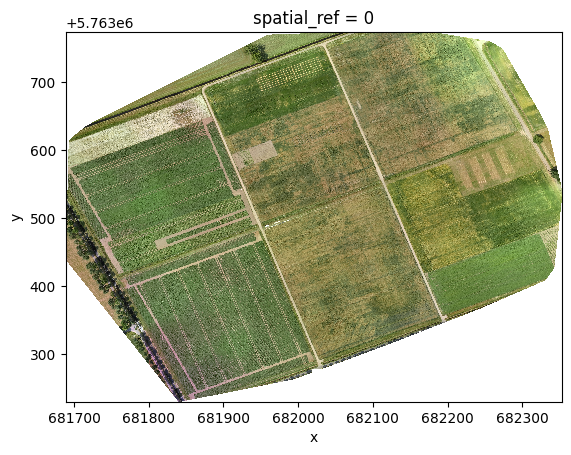

In [2]:
# ( an orthomosaic, stored at data/rgb/sfm relative from this notebook)

ortho = rxr.open_rasterio("data/rgb/sfm/ortho.tif", mode = "w", dtype= np.uint8)
ortho.plot.imshow()

## 2. Creating a chips-gdf

<Axes: >

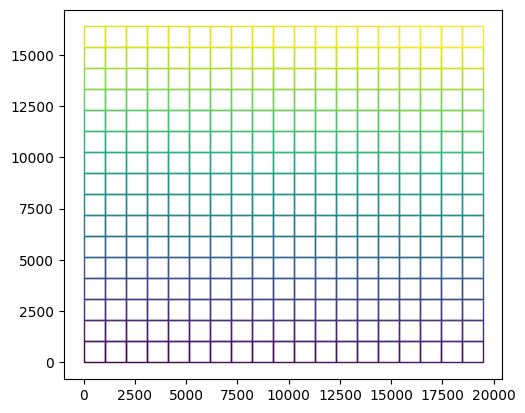

In [3]:
# define the size of the chips
input_dims = {"x":1024, "y":1024}

# the size of the total orthomosaic defines the shape
s_x = ortho.shape[2] 
s_y=ortho.shape[1] 
# and a crs to apply to the GDF
crs = ortho.rio.crs

chip_gdf = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, shape_x = s_x, shape_y = s_y, crs = crs)

# look at this lovely grid!
# oh wait, it is still in image/pixel-coordinates: from 0 -> 20000
chip_gdf.plot(facecolor="none", column = "box_id")

<Axes: >

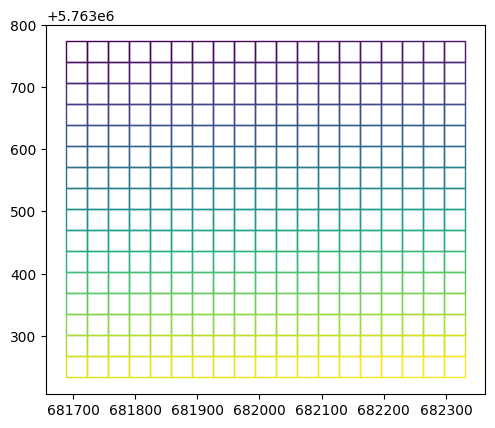

In [4]:
# let's fix those coordinates, by looking those coordinates up in the the input-raster.

#first find all these coordinates in the raster
chip_gdf = ug.compute.imgref_to_crsref_boxes(raster=ortho, gdf = chip_gdf)

# then apply this column as the new geometry columns
chip_gdf = chip_gdf.set_geometry(chip_gdf["c_geom"])

# now look at those coordinates! lovely
chip_gdf.plot(facecolor="none", column = "box_id")

In [5]:
# this c_geom is not great to have around. so lets get rid of it.
print(chip_gdf.head())
#geopandas will also not save double Shapely columns
chip_gdf = chip_gdf.drop(columns=["c_geom"])

print(chip_gdf.head())

   box_id                                           geometry  \
0       0  POLYGON ((681722.636 5763773.273, 681722.636 5...   
1       1  POLYGON ((681756.418 5763773.273, 681756.418 5...   
2       2  POLYGON ((681790.200 5763773.273, 681790.200 5...   
3       3  POLYGON ((681823.982 5763773.273, 681823.982 5...   
4       4  POLYGON ((681857.763 5763773.273, 681857.763 5...   

                                              c_geom  
0  POLYGON ((681722.636425 5763773.2727850005, 68...  
1  POLYGON ((681756.4181850001 5763773.2727850005...  
2  POLYGON ((681790.1999450001 5763773.2727850005...  
3  POLYGON ((681823.981705 5763773.2727850005, 68...  
4  POLYGON ((681857.7634650001 5763773.2727850005...  
   box_id                                           geometry
0       0  POLYGON ((681722.636 5763773.273, 681722.636 5...
1       1  POLYGON ((681756.418 5763773.273, 681756.418 5...
2       2  POLYGON ((681790.200 5763773.273, 681790.200 5...
3       3  POLYGON ((681823.982 5763773.2

In [ ]:
# now is also a good time to store the dataframe for later reference

chip_gdf.to_file("data/rgb/chips.geojson")

## 3. Cookiecutting the raster with the chips

Before doing this you can also develop a way to first select only the chips you want to chip.

Such as a boundary in which the chips should be in, taking an intersection etc.etc.


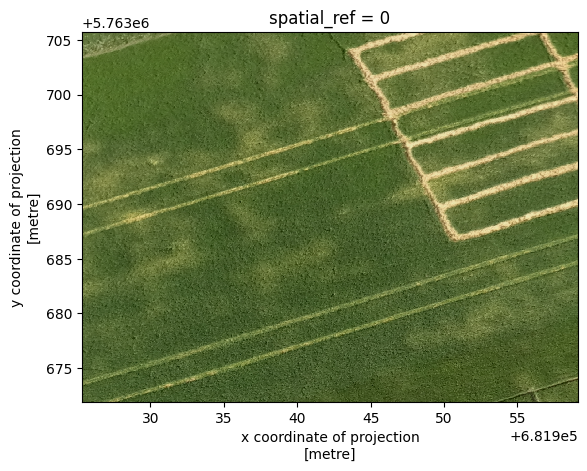

In [6]:
# The easiest way I find is with some list comprehension:
# Takes in ortho, and iterates over the chip_gdf
chip_list = [ortho.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chip_gdf.iterrows()]

#lets look at the 45th chip
chip_list[45].plot.imshow()

In [7]:
chip_list[45]

<xarray.DataArray (band: 4, y: 1024, x: 1024)>
[4194304 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 6.819e+05 6.819e+05 6.819e+05 ... 6.82e+05 6.82e+05
  * y            (y) float64 5.764e+06 5.764e+06 ... 5.764e+06 5.764e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  pix4dmapper
    scale_factor:      1.0
    add_offset:        0.0

A useful todo could be to implement this into a torchdatapipe, however I am still undecided wether this really clears up what is happening in the background

In [8]:
# Usually ML models do not like CRS coordinates, and the R,G,B as bands -> basically the xr.DataArray format is nice for geo-stuff, but not ML. So lets reformat them to more classical numpy images

#my example ortho has 4 bands: r,g,b and alpha: lets drop this last
chip_list = [img.sel(band = [1,2,3]) for img in chip_list]

#now we can transpose the x,y,band to the expected numpy colour images format
np_imgs = [np.transpose(img.values, (1,2,0)) for img in chip_list]


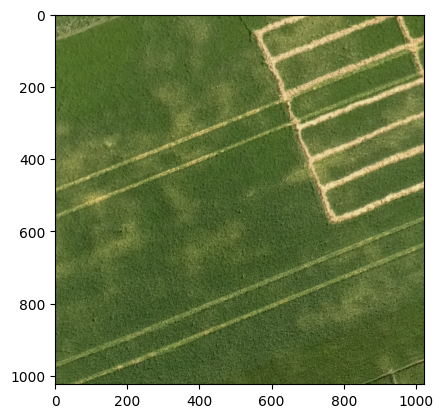

In [9]:
# the 45th image is still the same if we plot it
import matplotlib.pyplot as plt
plt.imshow(np_imgs[45])
# but the coordinates are now in image-coordinates

In [34]:
# this could be a training set or whatever, so it can all be saved to disk or whatever really
import os
from PIL import Image

def export_image_list(path, img_list):

    for i in range(len(img_list)):
        filename = f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)
        

In [ ]:
export_image_list(path = "data/rgb/chips", np_imgs)

## 4. And time to reconstruct all these chips back to a crs-ed orthomosaic


In [10]:
# To start we need an empty array to fill, which is references etc.
# wait: we have the ortho to do that!
empty_raster = xr.full_like(ortho.sel(band=[1,2,3]), fill_value=np.nan)

# we also need the input chip-gdf from earlier: which is why we saved it.
chip_gdf = chip_gdf

# takes a little while, clip can be true when your chipslist and chip_geoms is based on a smaller subset of the input raster
reconstructed = ug.compute.chips_to_single(chiplist = np_imgs, empty_raster = empty_raster, chip_geoms = chip_gdf, clip = False)

# this can also be done with a single-band raster such as ndvi, by selecting a single band above, and setting the single_band option to which xarray band be selected from the np_imgs



C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


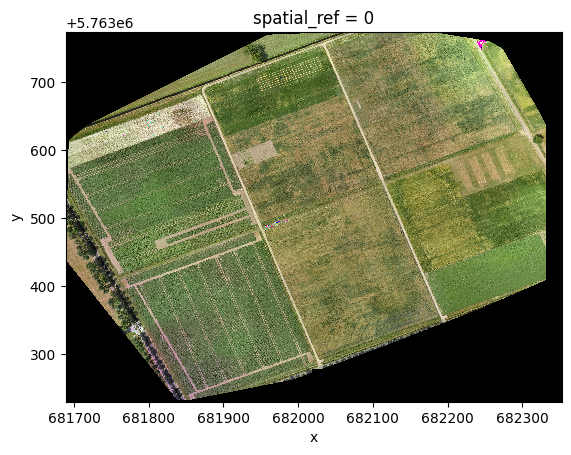

In [11]:
reconstructed.plot.imshow()
# admire the CRS-ed resutls for a minute, that is just glorious.
